#### Import Librarries and Dependencies

In [71]:
!pip install pyarabic

In [72]:
!pip install transformers

In [73]:
!git clone https://github.com/aub-mind/arabert.git


fatal: destination path 'arabert' already exists and is not an empty directory.


In [74]:
!pip install farasapy

In [75]:
!pip install data_helpers

In [76]:
from farasa.segmenter import FarasaSegmenter
from arabert.preprocess import ArabertPreprocessor
# from arabert.preprocess_arabert import never_split_tokens, preprocess
from pyarabic.araby import strip_tashkeel,strip_tatweel,normalize_ligature
from transformers import AutoTokenizer, TFAutoModel, AutoModel


In [77]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
import csv
import os, glob
from sklearn.metrics import accuracy_score , f1_score, auc
import requests
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.stem import ISRIStemmer
from imblearn.combine import SMOTETomek
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from tqdm import tqdm_notebook as tq
import tensorflow as tf

In [78]:
from keras.layers import merge, TimeDistributed
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional,GRU, GlobalMaxPool1D, Dropout, Conv1D, MaxPooling1D, Flatten,Convolution1D, Reshape
from keras.regularizers import L1L2
from keras.initializers import RandomNormal
from keras.layers.merge import Concatenate
from keras.models import model_from_json
import data_helpers as dh
# from data_helpers import alphabet


In [79]:
from pathlib import Path
import os

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords
nltk.download('stopwords')

import re
re1 = re.compile(r'  +')
import html
import unicodedata
import string 

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from collections import Counter
from nltk.util import ngrams

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### Preparing df

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
data = pd.read_csv('/content/drive/MyDrive/dialect_dataset.csv')
data.tail()

,id,dialect
458192,1019484980282580992,BH
458193,1021083283709407232,BH
458194,1017477537889431552,BH
458195,1022430374696239232,BH
458196,1022409931029458944,BH


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458197 non-null  int64 
 1   dialect  458197 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


In [83]:
data['id'] = data['id'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458197 non-null  object
 1   dialect  458197 non-null  object
dtypes: object(2)
memory usage: 7.0+ MB


In [84]:
id_col = data['id']
id_col

0         1175358310087892992
1         1175416117793349632
2         1175450108898565888
3         1175471073770573824
4         1175496913145217024
                 ...         
458192    1019484980282580992
458193    1021083283709407232
458194    1017477537889431552
458195    1022430374696239232
458196    1022409931029458944
Name: id, Length: 458197, dtype: object

In [85]:
id_col_arr = np.array(id_col) #make id vector to iterate request on it
id_col_arr = id_col_arr.tolist() #json need list to operate on it
id_col_arr[:5]

['1175358310087892992',
 '1175416117793349632',
 '1175450108898565888',
 '1175471073770573824',
 '1175496913145217024']

In [86]:
type(id_col_arr)

list

In [87]:
# get data from post request
max=len(data['id'])//1000
start=0
df_new=pd.DataFrame(columns=['id', 'tweet'])
data2 = pd.DataFrame()
for i in tq(range(max)):
  # print(str(i))
  end=start+1000
  results = requests.post('https://recruitment.aimtechnologies.co/ai-tasks', json=id_col_arr[start:end])

  r = pd.json_normalize(results.json()).T
  df_new['id'] = r.index
  df_new['tweet'] = r.values
  # print(df_new)
  data2 = data2.append(data.merge(df_new, on='id'))
  start=end
  
# the rest 197
results = requests.post('https://recruitment.aimtechnologies.co/ai-tasks', json=id_col_arr[start:])
r = pd.json_normalize(results.json()).T
df_new2=pd.DataFrame(columns=['id', 'tweet'])
df_new2['id'] = r.index
df_new2['tweet'] = r.values
data2 = data2.append(data.merge(df_new2, on='id'))

end

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/458 [00:00<?, ?it/s]

458000

In [88]:
#for check - random id's
response = requests.post('https://recruitment.aimtechnologies.co/ai-tasks', json=["1168585980309311488", "1175496913145217024", "1175358310087892992"])
response.json()

{'1168585980309311488': '@OmarAlmansuri كبسولة كل ست ساعات',
 '1175358310087892992': '@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .',
 '1175496913145217024': '@hmo2406 وين هل الغيبه  اخ محمد 🌸🌺'}

In [89]:
data2

,id,dialect,tweet
0,1175358310087892992,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1175416117793349632,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1175450108898565888,IQ,@KanaanRema مبين من كلامه خليجي
3,1175471073770573824,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1175496913145217024,IQ,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺
...,...,...,...
192,1019484980282580992,BH,@Al_mhbaa_7 مبسوطين منك اللي باسطانا😅
193,1021083283709407232,BH,@Zzainabali @P_ameerah والله ماينده ابش يختي
194,1017477537889431552,BH,@Al_mhbaa_7 شو عملنا لك حنا تهربي مننا احنا مس...
195,1022430374696239232,BH,@haneenalmwla الله يبارك فيها وبالعافيه 😋😋😋


In [90]:
full_data = data2.copy()

In [91]:
# save data after merge

#data2.to_csv('/content/drive/MyDrive/full_tweets.csv')

In [92]:
#data2 = pd.read_csv('full_tweets.csv')

#### Text Pre-processing

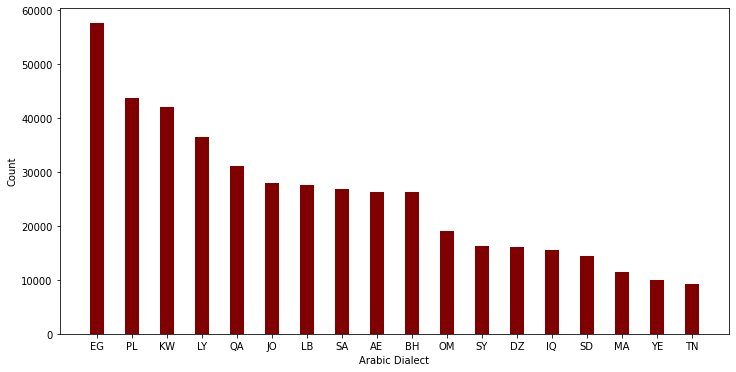

In [93]:
# Visualize the Arabic Dialects

plt.figure(figsize=(12,6))
plt.bar(data2.value_counts('dialect').index, data2.value_counts('dialect').values, color ='maroon',width = 0.4)
plt.xlabel("Arabic Dialect")
plt.ylabel("Count")
plt.show()

In [94]:
classes = data2.value_counts('dialect').index.size
classes

18

In [95]:
data2.value_counts('dialect').index

Index(['EG', 'PL', 'KW', 'LY', 'QA', 'JO', 'LB', 'SA', 'AE', 'BH', 'OM', 'SY',
       'DZ', 'IQ', 'SD', 'MA', 'YE', 'TN'],
      dtype='object', name='dialect')

In [96]:
# from sklearn.datasets import make_classification

# resample = SMOTETomek(random_state=42)#, sampling_strategy='majority')
# X, y = make_classification(n_classes=2, class_sep=2,
#                             weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
#                             n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=42)
# data_after = resample.fit(X,y)


In [97]:
# nltk.download('stopwords')

# arb_stopwords = nltk.corpus.stopwords.words('arabic')

In [98]:
# stemmer = ISRIStemmer()
model_name = "aubmindlab/bert-base-arabertv2"
arabert_tokenizer = AutoTokenizer.from_pretrained(model_name)
arabert_model = AutoModel.from_pretrained(model_name)
arabert_prep = ArabertPreprocessor(model_name=model_name)

def preprocess_text(tweet):
    outputs=[]
    tokenizer = TweetTokenizer()
    # stemSentence = ""
    tweet = str(tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'@[\w]+','',tweet)
    #replace punctuations with space
    tweet = re.sub(r"[,.;@#?!&$_]+\ *", " ", tweet)
    #find arabic letters only
    tweet = ' '.join(re.findall(r'[\u0600-\u06FF]+',tweet))
    #remove tashkeel
    tweet = strip_tashkeel(tweet)
    #remove tatweel
    tweet = strip_tatweel(tweet)
    #remove numbers from string
    pattern = r'[0-9]'
    # Match all digits in the string and replace them with an empty string
    tweet = re.sub(pattern, '', tweet)
    #apply normalization
    #tweet = normalize_ligature(tweet)
    #tokenize tweets
    tweet_tokens = tokenizer.tokenize(tweet)
    #tweet_tokens = tweet.split(' ')
    tweet_clean=[]
    for word in tweet_tokens: # Go through every word in your tokens list
        #if word not in string.punctuation:  # remove punctuation
        #    tweet_clean.append(word)
        word_reg = re.compile(r'\w')
        if word_reg.search(word):
            # stem = stemmer.stem(word)
            # text_preprocessed=arabert_prep.preprocess(word)
            # arabert_tokenizer.tokenize(text_preprocessed)
            # word=stemmer.stem(word)
            # word=arabert_prep.preprocess(word)
            tweet_clean.append(word)   
    outputs.append((' '.join(tweet_clean)))
    text_preprocessed=arabert_prep.preprocess(outputs)
    return text_preprocessed

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2022-03-13 20:23:59,078 - farasapy_logger - WARNING]: Be careful with large lines as they may break on intera

In [99]:
data2['cleaned_tweet'] = data2['tweet'].apply(preprocess_text)

In [100]:
# preprocess_text(data2['tweet'][1136783])

In [101]:
data2.head()

,id,dialect,tweet,cleaned_tweet
0,1175358310087892992,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,' لكن ب+ ال+ نهاي +ة ينتفض يغير '
1,1175416117793349632,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,' يعني هذا محسوب على ال+ بشر حي +ون +ه و+ وحشي...
2,1175450108898565888,IQ,@KanaanRema مبين من كلامه خليجي,' مبين من كلام +ه خليجي '
3,1175471073770573824,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,' يسلملي مرور +ك و+ روح +ك ال+ حلوه '
4,1175496913145217024,IQ,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,' وين هل ال+ غيبه أخ محمد '


In [102]:
# save data after mergeing and cleaning

#data2.to_csv('full_clean_tweets.csv')

In [103]:
data2.sample(10)

,id,dialect,tweet,cleaned_tweet
907,942067001161388032,LY,شن انظف دخان مينتا موجود بالسوق الان ؟,' شن انظف دخان مينتا موجود ب+ ال+ سوق الان '
578,990332317842509824,PL,@rawannakhleh1 هاد الطبيعي أصلاً ! مش عارفة مي...,' هاد ال+ طبيعي أصل +ا مش عارف +ة مين مفهم +هم...
752,1117370236985139200,OM,@ROP_MOE @alsa3di72 @taraneem_alamal @prince15...,' يمكن هذا منتهي بدل ما يعق في ال+ زباله قال أ...
894,888330421234130944,OM,@AlhosniSara كل عام وأنتِ بخييير سارة 😍🎉 سنة ح...,' كل عام و+ أنت ب+ خيير سار +ة سن +ة حلو +ة عل...
453,949697568849752064,TN,نام يا شعب\nتونس\nنوم العوافي,' نام يا شعب تونس نوم ال+ عوافي '
892,1144531297290899584,IQ,@bo_genhiit يدنيه شعندج مــن أهموم - ويهي\nعلي...,' يدني +ه شعندج من أهموم و+ يهي علي +ه و+ عن +...
280,1133295028133146624,JO,@tamerbadawy76 شتيغن احسن كنه بمليون مرة,' شتيغن أحسن كنه ب+ مليون مر +ة '
525,1064546788164755584,BH,@alghuraify66 عشان ما تشتاق لهم 😏😏😏,' عشان ما تشتاق ل+ +هم '
551,1041090267640672384,SY,@davut1374 هي مشكلة صعبة لانه ممكن أي واحد يعا...,' هي مشكل +ة صعب +ة لان +ه ممكن أي واحد يعادي ...
170,1096741609838952448,KW,شنو الجديد بالموضوع هذا نادي القادسيه مايفوز ا...,' شنو ال+ جديد ب+ ال+ موضوع هذا نادي ال+ قادسي...


In [104]:
data2.isna().sum()

id               0
dialect          0
tweet            0
cleaned_tweet    0
dtype: int64

In [105]:
full_data_clean = data2.copy()

In [106]:
full_data_clean_sampled = full_data_clean.sample(10000)
full_data_clean_sampled.head()

,id,dialect,tweet,cleaned_tweet
415,769310243063009280,EG,يارئيسي امبارح \nورئيسي دلوقتي \nيارئسي لبكره ...,' يارئيسي امبارح و+ رئيس +ي دلوقتي يارئسي ل+ ب...
543,1162487888476614912,KW,@shishtari فيه عاقل يصدق هالكلام 😏😏,' في +ه عاقل يصدق هالكلام '
190,1080591612214996992,TN,@salwa_tn دولة بعيييييييدة ، كل واحد يحكمها يو...,' دول +ة ب+ عييد +ة كل واحد يحكم +ها يولي غول ...
793,1150841854134575232,KW,@mrskuwait56 @Almajlliss هذا المفروض شتبي تسوي...,' هذا ال+ مفروض شتبي تسوي ب+ ال+ جنسي +ة '
893,1076974105818288000,SA,@rooooo7y555 @00_kh_ مفهوم وخلصنا ندور الثانية...,' مفهوم و+ خلص +نا ندور ال+ ثاني +ة ال+ حين '


In [107]:
full_data_clean_sampled.shape

(10000, 4)

In [108]:
full_data_clean_sampled.duplicated().sum()

0

In [109]:
full_data_clean_sampled.dialect.value_counts()#normalize=True)

EG    1309
KW     983
PL     924
LY     752
QA     674
SA     621
LB     594
JO     589
AE     574
BH     574
OM     419
SY     363
IQ     344
DZ     340
SD     299
YE     230
MA     218
TN     193
Name: dialect, dtype: int64

#### Split data and transformation before modeling

In [110]:
full_data_clean_sampled_ml = full_data_clean_sampled.copy()

In [111]:
# Split data

trainData, testData = train_test_split(full_data_clean_sampled_ml, test_size=0.2, random_state=42)
print(trainData.shape)
print(testData.shape)

(8000, 4)
(2000, 4)


In [112]:
# Tf-idf transform

vectorizer = TfidfVectorizer()

train_features = vectorizer.fit_transform(trainData["cleaned_tweet"])
test_features = vectorizer.transform(testData["cleaned_tweet"])
print(train_features.shape)

(8000, 20797)


In [113]:
print(vectorizer.get_feature_names()[470:500])


['أسياد', 'أشار', 'أشارك', 'أشب', 'أشباح', 'أشبه', 'أشتر', 'أشتغالات', 'أشجع', 'أشخاص', 'أشد', 'أشر', 'أشرار', 'أشرب', 'أشرح', 'أشرف', 'أشرفلو', 'أشغال', 'أشقاء', 'أشقر', 'أشك', 'أشكال', 'أشكر', 'أشكك', 'أشهد', 'أشهر', 'أشو', 'أشواق', 'أشوف', 'أشوفك']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# PCA for dimensionality reduction

# train_features_df = pd.DataFrame(train_features)


In [ ]:
# from sklearn.decomposition import TruncatedSVD
# clf = TruncatedSVD(1000)

# df_train_pca = clf.fit_transform(train_features)
# df_train_pca

In [ ]:


# Store as dataframe and print
# df_train_pca = pd.DataFrame(df_train_pca)
# print(df_train_pca.shape) 
# df_train_pca.round(2).head()

In [ ]:
# train_features_df.head(10)

In [ ]:
# PCA for dimensionality reduction

#test_features_df = pd.DataFrame(test_features)
# pca = PCA()
# df_test_pca = pca.fit_transform(test_features_df)

# # Store as dataframe and print
# df_pca = pd.DataFrame(df_test_pca)
# print(df_test_pca.shape) 
# df_test_pca.round(2).head()

#### MachineLearning Model

In [ ]:
'''
Here we try different Algorithm to know the best one to work with
An empty list is first defined and models are appended to it
Cross validation is then instantiated in order to evaluate how different algorithm performed

'''
# def ModelSelection():
    
#     models = []
#     models.append(('KNN', KNeighborsClassifier(n_neighbors = 55)))
#     models.append(('NB', MultinomialNB()))
#     # models.append(('LR', LogisticRegression(max_iter=2050)))
#     # models.append(('SDG', SGDClassifier()))
#     models.append(('SVM', SVC(kernel = 'rbf', random_state = 0)))

#     results = []
#     names = []
#     #evaluating the algorithm
#     for name, model in models:
#       kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
#       cv_results = cross_val_score(model, training_features, trainData['dialect'], cv=kfold, scoring='accuracy')
#       results.append(cv_results)
#       names.append(name)
#       print(f"{name}: {cv_results.mean()} ({cv_results.std()})")
    
# ModelSelection()

KNN: 0.03505048214023418 (0.00032146653035817926)
NB: 0.3312636226184662 (0.0011241921319426974)


In [114]:
# LR

model_lr = LogisticRegression(verbose= 0,n_jobs=-1, solver= 'lbfgs', penalty= 'l2', C= 10,multi_class='multinomial', max_iter=10)
model_lr.fit( train_features, trainData['dialect'])

pred_lr = model_lr.predict(test_features)

print(accuracy_score(testData['dialect'], pred_lr))
print(classification_report(testData['dialect'], pred_lr))

0.293
              precision    recall  f1-score   support

          AE       0.16      0.04      0.07       120
          BH       0.32      0.06      0.09       126
          DZ       0.36      0.06      0.11        65
          EG       0.44      0.68      0.53       274
          IQ       0.71      0.07      0.13        72
          JO       0.11      0.08      0.09       106
          KW       0.23      0.62      0.34       202
          LB       0.36      0.35      0.36       120
          LY       0.25      0.45      0.32       157
          MA       0.00      0.00      0.00        44
          OM       0.30      0.04      0.07        77
          PL       0.29      0.33      0.31       195
          QA       0.28      0.31      0.29       129
          SA       0.19      0.19      0.19       105
          SD       0.71      0.09      0.16        54
          SY       0.14      0.01      0.03        71
          TN       0.00      0.00      0.00        42
          YE       0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
# SVC

model_svc = SVC(kernel = 'rbf', random_state = 42)
model_svc.fit( train_features, trainData['dialect'])

pred_svc = model_svc.predict(test_features)

print(accuracy_score(testData['dialect'], pred_svc))
print(classification_report(testData['dialect'], pred_svc))

0.3085
              precision    recall  f1-score   support

          AE       0.12      0.01      0.02       120
          BH       0.20      0.01      0.02       126
          DZ       0.67      0.06      0.11        65
          EG       0.37      0.80      0.51       274
          IQ       0.00      0.00      0.00        72
          JO       0.25      0.04      0.07       106
          KW       0.22      0.75      0.33       202
          LB       0.54      0.24      0.33       120
          LY       0.47      0.38      0.42       157
          MA       1.00      0.02      0.04        44
          OM       0.00      0.00      0.00        77
          PL       0.26      0.50      0.34       195
          QA       0.42      0.23      0.30       129
          SA       0.40      0.11      0.18       105
          SD       1.00      0.09      0.17        54
          SY       0.33      0.01      0.03        71
          TN       0.00      0.00      0.00        42
          YE       1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
# NBC

model_nb = MultinomialNB(alpha=1)
model_nb.fit( train_features, trainData['dialect'])

pred_nb = model_nb.predict(test_features)

print(accuracy_score(testData['dialect'], pred_nb))
print(classification_report(testData['dialect'], pred_nb))

0.238
              precision    recall  f1-score   support

          AE       1.00      0.01      0.02       120
          BH       0.00      0.00      0.00       126
          DZ       1.00      0.03      0.06        65
          EG       0.19      0.98      0.32       274
          IQ       0.00      0.00      0.00        72
          JO       1.00      0.02      0.04       106
          KW       0.27      0.55      0.36       202
          LB       0.71      0.08      0.15       120
          LY       0.76      0.08      0.15       157
          MA       0.00      0.00      0.00        44
          OM       0.00      0.00      0.00        77
          PL       0.38      0.28      0.32       195
          QA       0.60      0.09      0.16       129
          SA       0.50      0.01      0.02       105
          SD       0.00      0.00      0.00        54
          SY       0.00      0.00      0.00        71
          TN       0.00      0.00      0.00        42
          YE       0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### DeepLearning Model

In [120]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('arabic'))


In [121]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 150
# This is fixed.
EMBEDDING_DIM = 64

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)#, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(full_data_clean['cleaned_tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 237590 unique tokens.


In [122]:
X = tokenizer.texts_to_sequences(full_data_clean['cleaned_tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (458197, 150)


In [123]:
Y = pd.get_dummies(full_data_clean['dialect']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (458197, 18)


In [124]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42, shuffle=True, stratify=Y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(366557, 150) (366557, 18)
(91640, 150) (91640, 18)


In [125]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(18, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 64)           3200000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 150, 64)          0         
 ropout1D)                                                       
                                                                 
 lstm_4 (LSTM)               (None, 100)               66000     
                                                                 
 dense_4 (Dense)             (None, 18)                1818      
                                                                 
Total params: 3,267,818
Trainable params: 3,267,818
Non-trainable params: 0
_________________________________________________________________
None


In [126]:
epochs = 3
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/3
4582/4582 [==============================] - 2333s 508ms/step - loss: 1.9921 - accuracy: 0.3641 - val_loss: 1.7154 - val_accuracy: 0.4578
Epoch 2/3
4582/4582 [==============================] - 2327s 508ms/step - loss: 1.5799 - accuracy: 0.5030 - val_loss: 1.5980 - val_accuracy: 0.5011
Epoch 3/3
4582/4582 [==============================] - 2308s 504ms/step - loss: 1.4063 - accuracy: 0.5602 - val_loss: 1.5724 - val_accuracy: 0.5148


In [127]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2864/2864 [==============================] - 137s 48ms/step - loss: 1.5582 - accuracy: 0.5192
Test set
  Loss: 1.558
  Accuracy: 0.519


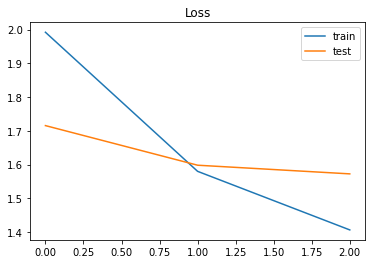

In [128]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

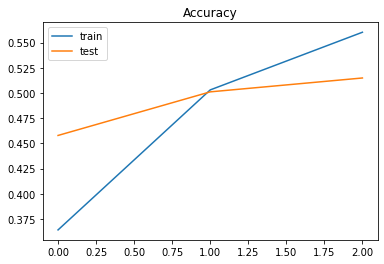

In [132]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [137]:
new_tweet = ['كبسولة كل ست ساعات']
seq = tokenizer.texts_to_sequences(new_tweet)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['EG', 'PL', 'KW', 'LY', 'QA', 'JO', 'LB', 'SA', 'AE', 'BH', 'OM', 'SY', 'DZ', 'IQ', 'SD', 'MA', 'YE', 'TN']
print(pred, labels[np.argmax(pred)])

[[0.02486951 0.03202857 0.04158586 0.24161778 0.07006436 0.04041369
  0.02298783 0.10524245 0.02333692 0.03558577 0.02527908 0.04096925
  0.02291992 0.01708797 0.10529894 0.06886421 0.05138178 0.03046612]] LY


In [138]:
new_tweet = ['وين هل الغيبه اخ محمد ']
seq = tokenizer.texts_to_sequences(new_tweet)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['EG', 'PL', 'KW', 'LY', 'QA', 'JO', 'LB', 'SA', 'AE', 'BH', 'OM', 'SY', 'DZ', 'IQ', 'SD', 'MA', 'YE', 'TN']
print(pred, labels[np.argmax(pred)])

[[0.05375696 0.05769958 0.04409723 0.05632733 0.07494097 0.05493006
  0.05060498 0.07609044 0.05999411 0.04530567 0.04362554 0.04806991
  0.06282713 0.04315685 0.04981358 0.07353661 0.05541021 0.04981282]] SA


### Thank You!

In [66]:
vocab_size = 7753
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 6700


In [69]:
#Creating the Bidirectional LSTM model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          496192    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 607,681
Trainable params: 607,681
Non-tr

In [70]:
num_epochs = 30
history = model.fit(train_features, trainData['dialect'], epochs=num_epochs, verbose=0)
history

UnimplementedError: ignored

In [ ]:
#Plotting LSTM model

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
#TEST LSTM model 
## if the result near 1 is positive
#### if the result near 0 is negative 

sentence = ["يسلملي مرورك وروحك الحلوه"]
sequences = tf.keras.preprocessing.text.tokenizer.texts_to_sequences(sentence)
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))